<a href="https://colab.research.google.com/github/skashyapsri/Absorbance-Prediction-Using-ML/blob/main/EVOO_Pigment_Analysis_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pigment Analysis using Deep Learning


## Import Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import random

## Load Pigments Data

In [22]:
pigments_data = pd.read_csv('https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/pigments/pigments.csv', delimiter=';', comment='#')
MW = pigments_data.iloc[0, 1:].astype(float).values  # g/mol
pigments_data = pigments_data.iloc[2:].reset_index(drop=True)
pigments_data = pigments_data.rename(columns={'Wavelength (nm)': 'Wavelength'})
pigments_data['Wavelength'] = pd.to_numeric(pigments_data['Wavelength'], errors='coerce')
pigments_data = pigments_data.dropna()

## Define Helper Functions


In [23]:
def apply_baseline_correction(absorbance):
    return absorbance - np.min(absorbance)

def select_wavelength_range(data, start, end):
    return data[(data['Wavelength'] >= start) & (data['Wavelength'] <= end)]

## Define PyTorch Model

## Model Architecture

Key aspects of `DeconvolutionModel`:

1. **Type**: Fully connected neural network
2. **Layers**: Single layer with learnable parameters
3. **Input**: Normalized extinction coefficients (epsilon) of pigments
4. **Output**: Calculated absorbance spectrum


## Key Features

1. **Learnable Parameters**: The model learns the concentrations of each pigment, represented by `self.concentrations`.
2. **Non-Negativity Constraint**: ReLU activation ensures that the learned concentrations are always non-negative, which is physically meaningful for concentration values.
3. **Linear Combination**: The forward pass computes a linear combination of the input extinction coefficients, weighted by the learned concentrations.
4. **Optical Path Length**: The result is multiplied by `b`, representing the optical path length.


In [24]:
class DeconvolutionModel(nn.Module):
    def __init__(self, num_pigments, seed=42):
        super(DeconvolutionModel, self).__init__()
        torch.manual_seed(seed)
        self.concentrations = nn.Parameter(torch.rand(num_pigments))

    def forward(self, epsilon):
        positive_concentrations = nn.functional.relu(self.concentrations)
        return torch.matmul(positive_concentrations, epsilon) * b

## Define Training Function

## Training Process

1. **Loss Function**: Mean Squared Error (MSE) between calculated and experimental absorbance spectra.
2. **Optimizer**: Adam optimizer with a learning rate of 0.001.
3. **Training Duration**: 5000 epochs by default, with the option to adjust.
4. **Batch Processing**: The entire dataset is used in each forward pass (no mini-batches).

In [25]:
def set_seed(seed=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [26]:
def train_model(A_exp, epsilon, num_epochs=5000, learning_rate=0.001,seed=42):
    set_seed(seed)
    model = DeconvolutionModel(epsilon.shape[0], seed=seed)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    A_exp_tensor = torch.FloatTensor(A_exp)
    epsilon_tensor = torch.FloatTensor(epsilon)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        A_calc = model(epsilon_tensor)
        loss = criterion(A_calc, A_exp_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return model

## Define Analysis Function

In [27]:
def analyze_with_deconvolution_model(file_url, pigments_data):

    print(f"\nAnalyzing dataset: {file_url.split('/')[-1]}")

    evoo_samples = pd.read_csv(file_url, delimiter=';')
    evoo_samples.columns = ['Wavelength', 'Absorbance']
    evoo_samples['Wavelength'] = pd.to_numeric(evoo_samples['Wavelength'], errors='coerce')
    evoo_samples = evoo_samples.dropna()

    wavelength_start, wavelength_end = 390, 720
    evoo_samples = select_wavelength_range(evoo_samples, wavelength_start, wavelength_end)
    pigments_data_filtered = select_wavelength_range(pigments_data, wavelength_start, wavelength_end)

    wavelengths = evoo_samples['Wavelength'].values
    A_exp = evoo_samples['Absorbance'].values.astype(float)
    A_exp = apply_baseline_correction(A_exp)

    epsilon = pigments_data_filtered.iloc[:, 1:].astype(float).values.T
    epsilon = np.maximum(epsilon, 0)
    epsilon_max = np.max(epsilon, axis=1, keepdims=True)
    epsilon_max[epsilon_max == 0] = 1
    epsilon_normalized = epsilon / epsilon_max

    # model = train_model(A_exp, epsilon_normalized)
    seed = 42
    set_seed(seed)
    model = train_model(A_exp, epsilon_normalized, seed=seed)
    final_concentrations = nn.functional.relu(model.concentrations).detach().numpy()
    with torch.no_grad():
        A_calc = model(torch.FloatTensor(epsilon_normalized)).numpy()
    A_calc = np.dot(final_concentrations, epsilon_normalized) * b
    r2 = r2_score(A_exp, A_calc)

    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, A_exp, 'k-', label='Experimental', linewidth=2)
    plt.plot(wavelengths, A_calc, 'g-', label='Calculated', linewidth=2)
    for i, name in enumerate(pigments_data.columns[1:]):
        plt.plot(wavelengths, final_concentrations[i] * epsilon_normalized[i] * b, label=name)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.legend()
    plt.title(f'Experimental vs Calculated Absorbance - {file_url.split("/")[-1]}')
    plt.show()

    print(f"R-square = {r2:.6f}")
    print("    PIGMENT CONCENTRATION")
    print("-------------------------------")
    total_concentration = 0
    # for i, name, conc in zip(final_concentrations, pigments_data.columns[1:], final_concentrations):
        # conc_mg_kg = (conc * MW[pigments_data.columns[1:].get_loc(name)] * 1000 / evoo_density)
    for i, name in enumerate(pigments_data.columns[1:]):
      conc_mg_kg = (final_concentrations[i] / epsilon_max[i])[0] * b * MW[i] * 1000 / evoo_density
      if conc_mg_kg > 1e4:
        print(f"{name:<12} = ********* mg/kg")
      else:
        print(f"{name:<12} = {conc_mg_kg:9.3f} mg/kg")
        total_concentration += conc_mg_kg
    print("-------------------------------")
    print(f"PIGMENT TOTAL = {total_concentration:9.3f} mg/kg")

## Set Constants and Define Datasets

In [28]:
b = 1.0  # optical path in cm
evoo_density = 0.9  # EVOO density in g/ml
datasets = [
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/evoo_test.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/fresh_evoo.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/mais_seed_oil.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/monocultivar_frantoio.csv',
    'https://raw.githubusercontent.com/sandroj87/EVOODec/refs/heads/main/evoodec/spectra/rapeseed_oil.csv'
]


## Model Interpretation

- The learned `concentrations` directly correspond to the relative amounts of each pigment in the EVOO sample.
- The model essentially performs a spectral deconvolution, separating the contributions of individual pigments to the overall absorbance spectrum.

## Advantages of This Approach

1. **Physical Interpretability**: The model's structure mirrors the Beer-Lambert law, making the results physically meaningful.
2. **Flexibility**: Can be easily adapted to different numbers of pigments or spectral ranges.
3. **Non-Negativity**: Ensures physically realistic (non-negative) concentration values.
4. **End-to-End Learning**: Directly learns concentrations from spectral data without intermediate steps.

## Analysis of EVOO


Analyzing dataset: evoo_test.csv
Epoch [500/5000], Loss: 0.0090
Epoch [1000/5000], Loss: 0.0045
Epoch [1500/5000], Loss: 0.0027
Epoch [2000/5000], Loss: 0.0020
Epoch [2500/5000], Loss: 0.0016
Epoch [3000/5000], Loss: 0.0014
Epoch [3500/5000], Loss: 0.0012
Epoch [4000/5000], Loss: 0.0010
Epoch [4500/5000], Loss: 0.0009
Epoch [5000/5000], Loss: 0.0008


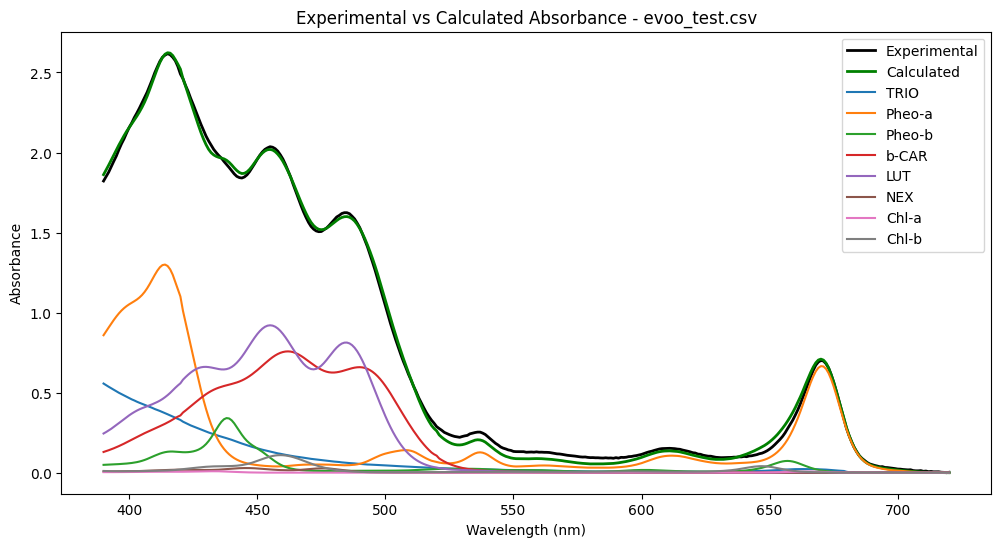

R-square = 0.998909
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =    10.830 mg/kg
Pheo-b       =     1.880 mg/kg
b-CAR        =     3.413 mg/kg
LUT          =     4.391 mg/kg
NEX          =     0.155 mg/kg
Chl-a        =     0.081 mg/kg
Chl-b        =     0.940 mg/kg
-------------------------------
PIGMENT TOTAL =    21.691 mg/kg


In [29]:
analyze_with_deconvolution_model(datasets[0], pigments_data)

## Analysis of Fresh EVOO


Analyzing dataset: fresh_evoo.csv
Epoch [500/5000], Loss: 0.0236
Epoch [1000/5000], Loss: 0.0038
Epoch [1500/5000], Loss: 0.0027
Epoch [2000/5000], Loss: 0.0021
Epoch [2500/5000], Loss: 0.0016
Epoch [3000/5000], Loss: 0.0013
Epoch [3500/5000], Loss: 0.0011
Epoch [4000/5000], Loss: 0.0010
Epoch [4500/5000], Loss: 0.0009
Epoch [5000/5000], Loss: 0.0008


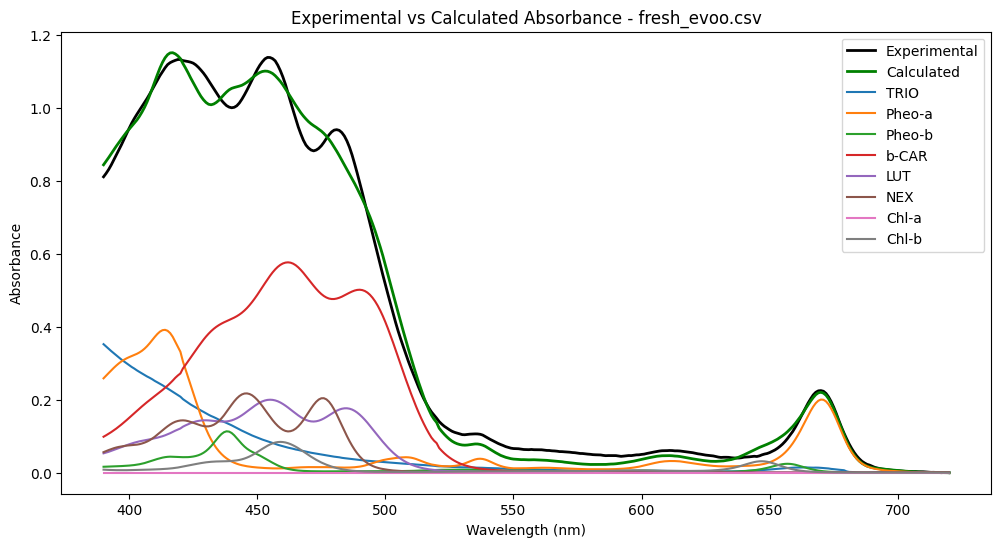

R-square = 0.995542
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     3.260 mg/kg
Pheo-b       =     0.625 mg/kg
b-CAR        =     2.595 mg/kg
LUT          =     0.954 mg/kg
NEX          =     1.151 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     0.722 mg/kg
-------------------------------
PIGMENT TOTAL =     9.307 mg/kg


In [30]:
analyze_with_deconvolution_model(datasets[1], pigments_data)

## Analysis of Maize Seed Oil


Analyzing dataset: mais_seed_oil.csv
Epoch [500/5000], Loss: 0.0336
Epoch [1000/5000], Loss: 0.0212
Epoch [1500/5000], Loss: 0.0145
Epoch [2000/5000], Loss: 0.0098
Epoch [2500/5000], Loss: 0.0069
Epoch [3000/5000], Loss: 0.0053
Epoch [3500/5000], Loss: 0.0046
Epoch [4000/5000], Loss: 0.0044
Epoch [4500/5000], Loss: 0.0043
Epoch [5000/5000], Loss: 0.0043


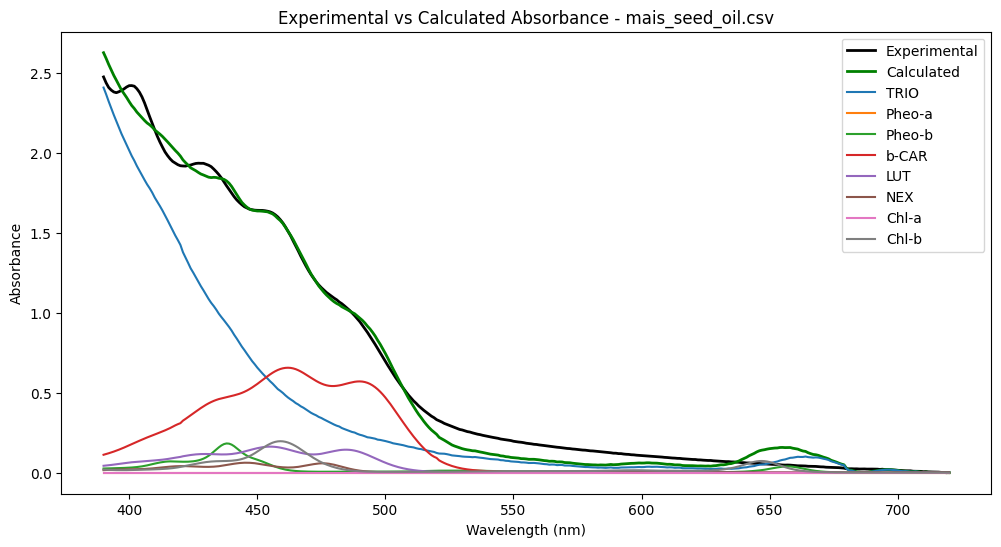

R-square = 0.992892
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     0.000 mg/kg
Pheo-b       =     1.007 mg/kg
b-CAR        =     2.955 mg/kg
LUT          =     0.777 mg/kg
NEX          =     0.331 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     1.685 mg/kg
-------------------------------
PIGMENT TOTAL =     6.756 mg/kg


In [31]:
analyze_with_deconvolution_model(datasets[2], pigments_data)

## Analysis of Monocultivar Frantoio


Analyzing dataset: monocultivar_frantoio.csv
Epoch [500/5000], Loss: 0.0048
Epoch [1000/5000], Loss: 0.0022
Epoch [1500/5000], Loss: 0.0013
Epoch [2000/5000], Loss: 0.0010
Epoch [2500/5000], Loss: 0.0009
Epoch [3000/5000], Loss: 0.0008
Epoch [3500/5000], Loss: 0.0008
Epoch [4000/5000], Loss: 0.0008
Epoch [4500/5000], Loss: 0.0008
Epoch [5000/5000], Loss: 0.0008


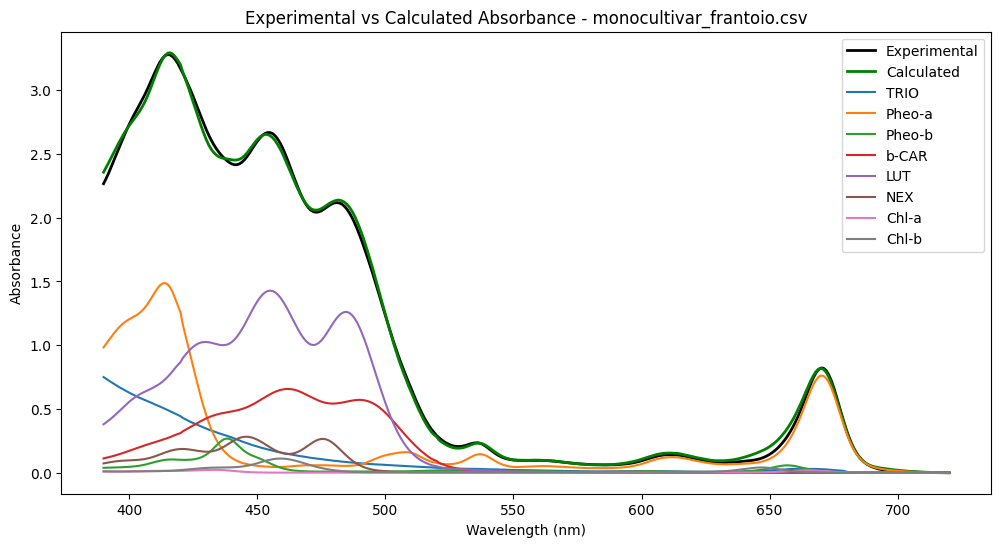

R-square = 0.999351
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =    12.395 mg/kg
Pheo-b       =     1.476 mg/kg
b-CAR        =     2.959 mg/kg
LUT          =     6.812 mg/kg
NEX          =     1.495 mg/kg
Chl-a        =     0.198 mg/kg
Chl-b        =     0.951 mg/kg
-------------------------------
PIGMENT TOTAL =    26.286 mg/kg


In [32]:
analyze_with_deconvolution_model(datasets[3], pigments_data)

## Analysis of Rapeseed Oil


Analyzing dataset: rapeseed_oil.csv
Epoch [500/5000], Loss: 0.0589
Epoch [1000/5000], Loss: 0.0344
Epoch [1500/5000], Loss: 0.0239
Epoch [2000/5000], Loss: 0.0188
Epoch [2500/5000], Loss: 0.0162
Epoch [3000/5000], Loss: 0.0143
Epoch [3500/5000], Loss: 0.0127
Epoch [4000/5000], Loss: 0.0110
Epoch [4500/5000], Loss: 0.0092
Epoch [5000/5000], Loss: 0.0075


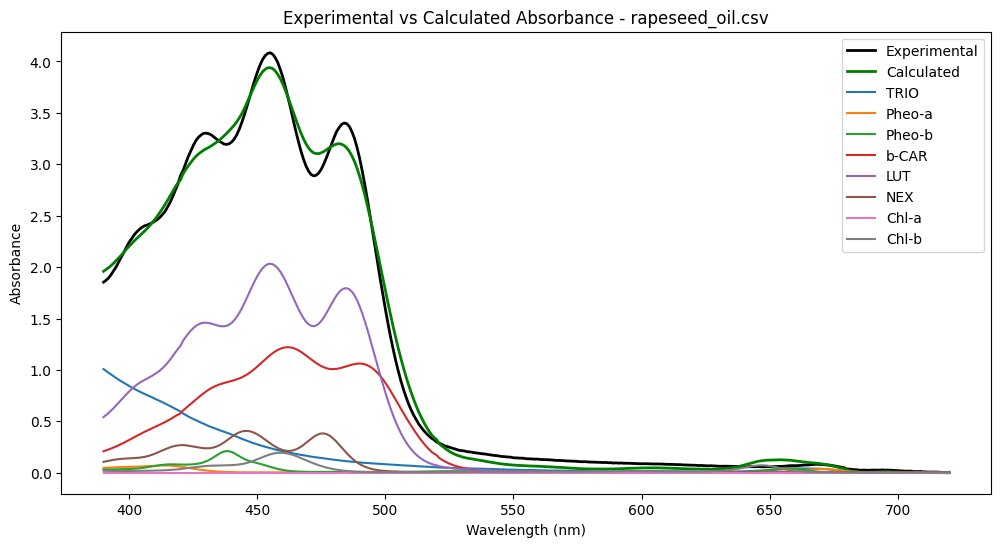

R-square = 0.996130
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     0.592 mg/kg
Pheo-b       =     1.159 mg/kg
b-CAR        =     5.498 mg/kg
LUT          =     9.694 mg/kg
NEX          =     2.154 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     1.660 mg/kg
-------------------------------
PIGMENT TOTAL =    20.756 mg/kg


In [33]:
analyze_with_deconvolution_model(datasets[4], pigments_data)

## Regularized Adaptive Deconvolution Model Architecture

Key aspects of `RegularizedAdaptiveDeconvolutionModel`:

1. **Type**: Fully connected neural network
2. **Layers**: Single layer with learnable parameters
3. **Input**: Normalized extinction coefficients (epsilon) of pigments
4. **Output**: Calculated absorbance spectrum

## Key Features
In addition to the Feature of the DeconvolutionModel
1. **L2 Regularization**: Added L2 norm of the concentrations to prevent overfitting and encourage smoother solutions.

## Training Process

1. **Loss Function**:
   - Primary: Mean Squared Error (MSE) between calculated and experimental absorbance spectra
   - Regularization: L2 loss on the concentration parameters

2. **Optimizer**: Adam optimizer with an initial learning rate of 0.001 and weight decay for additional L2 regularization

3. **Learning Rate Scheduling**: ReduceLROnPlateau scheduler to adapt the learning rate based on loss improvement

4. **Training Duration**: Up to 10,000 epochs with early stopping

5. **Batch Processing**: The entire dataset is used in each forward pass (no mini-batches)

6. **Early Stopping**: Training stops if no improvement is seen for a specified number of epochs (patience)

7. **Gradient Clipping**: Applied to prevent exploding gradients and stabilize training


## Key Improvements

1. **Regularization**: L2 regularization helps prevent overfitting and encourages more physically realistic concentration values.

2. **Adaptive Learning Rate**: The learning rate scheduler allows for more efficient training, starting with larger updates and fine-tuning with smaller updates as training progresses.

3. **Extended Training**: Increased maximum epochs allow for potentially longer training when beneficial.

4. **Early Stopping**: Prevents unnecessary computation and potential overfitting by stopping training when no further improvement is observed.

5. **Gradient Clipping**: Enhances training stability by preventing extreme parameter updates.

6. **Improved Monitoring**: More detailed logging of loss components (MSE and L2) for better insight into the training process.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegularizedAdaptiveDeconvolutionModel(nn.Module):
    def __init__(self, num_pigments, seed=42):
        super(RegularizedAdaptiveDeconvolutionModel, self).__init__()
        torch.manual_seed(seed)
        self.concentrations = nn.Parameter(torch.rand(num_pigments))

    def forward(self, epsilon):
        positive_concentrations = nn.functional.relu(self.concentrations)
        return torch.matmul(positive_concentrations, epsilon) * b

    def l2_loss(self):
        return torch.sum(self.concentrations**2)

def train_regularized_adaptive_model(A_exp, epsilon, num_epochs=10000, learning_rate=0.001, l2_lambda=1e-5, seed=42):
    set_seed(seed)
    model = RegularizedAdaptiveDeconvolutionModel(epsilon.shape[0], seed=seed)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)

    A_exp_tensor = torch.FloatTensor(A_exp)
    epsilon_tensor = torch.FloatTensor(epsilon)

    best_loss = float('inf')
    best_model = None
    patience = 1000
    no_improve_count = 0

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        A_calc = model(epsilon_tensor)
        mse_loss = criterion(A_calc, A_exp_tensor)
        l2_loss = l2_lambda * model.l2_loss()
        loss = mse_loss + l2_loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, MSE: {mse_loss.item():.4f}, L2: {l2_loss.item():.4f}')

    model.load_state_dict(best_model)
    return model

In [35]:
def analyze_with_regularized_adaptive_model(file_url, pigments_data):

    print(f"\nAnalyzing dataset: {file_url.split('/')[-1]}")

    evoo_samples = pd.read_csv(file_url, delimiter=';')
    evoo_samples.columns = ['Wavelength', 'Absorbance']
    evoo_samples['Wavelength'] = pd.to_numeric(evoo_samples['Wavelength'], errors='coerce')
    evoo_samples = evoo_samples.dropna()

    wavelength_start, wavelength_end = 390, 720
    evoo_samples = select_wavelength_range(evoo_samples, wavelength_start, wavelength_end)
    pigments_data_filtered = select_wavelength_range(pigments_data, wavelength_start, wavelength_end)

    wavelengths = evoo_samples['Wavelength'].values
    A_exp = evoo_samples['Absorbance'].values.astype(float)
    A_exp = apply_baseline_correction(A_exp)

    epsilon = pigments_data_filtered.iloc[:, 1:].astype(float).values.T
    epsilon = np.maximum(epsilon, 0)
    epsilon_max = np.max(epsilon, axis=1, keepdims=True)
    epsilon_max[epsilon_max == 0] = 1
    epsilon_normalized = epsilon / epsilon_max

    # model = train_model(A_exp, epsilon_normalized)
    seed = 42
    set_seed(seed)
    model = train_regularized_adaptive_model(A_exp, epsilon_normalized, seed=seed)
    final_concentrations = nn.functional.relu(model.concentrations).detach().numpy()
    with torch.no_grad():
        A_calc = model(torch.FloatTensor(epsilon_normalized)).numpy()
    A_calc = np.dot(final_concentrations, epsilon_normalized) * b
    r2 = r2_score(A_exp, A_calc)

    plt.figure(figsize=(12, 6))
    plt.plot(wavelengths, A_exp, 'k-', label='Experimental', linewidth=2)
    plt.plot(wavelengths, A_calc, 'g-', label='Calculated', linewidth=2)
    for i, name in enumerate(pigments_data.columns[1:]):
        plt.plot(wavelengths, final_concentrations[i] * epsilon_normalized[i] * b, label=name)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.legend()
    plt.title(f'Experimental vs Calculated Absorbance - {file_url.split("/")[-1]}')
    plt.show()

    print(f"R-square = {r2:.6f}")
    print("    PIGMENT CONCENTRATION")
    print("-------------------------------")
    total_concentration = 0
    # for i, name, conc in zip(final_concentrations, pigments_data.columns[1:], final_concentrations):
        # conc_mg_kg = (conc * MW[pigments_data.columns[1:].get_loc(name)] * 1000 / evoo_density)
    for i, name in enumerate(pigments_data.columns[1:]):
      conc_mg_kg = (final_concentrations[i] / epsilon_max[i])[0] * b * MW[i] * 1000 / evoo_density
      if conc_mg_kg > 1e4:
        print(f"{name:<12} = ********* mg/kg")
      else:
        print(f"{name:<12} = {conc_mg_kg:9.3f} mg/kg")
        total_concentration += conc_mg_kg
    print("-------------------------------")
    print(f"PIGMENT TOTAL = {total_concentration:9.3f} mg/kg")

## Analysis of EVOO


Analyzing dataset: evoo_test.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/10000], Loss: 0.0091, MSE: 0.0090, L2: 0.0000
Epoch [1000/10000], Loss: 0.0046, MSE: 0.0045, L2: 0.0000
Epoch [1500/10000], Loss: 0.0027, MSE: 0.0027, L2: 0.0000
Epoch [2000/10000], Loss: 0.0020, MSE: 0.0020, L2: 0.0000
Epoch [2500/10000], Loss: 0.0016, MSE: 0.0016, L2: 0.0000
Epoch [3000/10000], Loss: 0.0014, MSE: 0.0014, L2: 0.0000
Epoch [3500/10000], Loss: 0.0012, MSE: 0.0012, L2: 0.0000
Epoch [4000/10000], Loss: 0.0010, MSE: 0.0010, L2: 0.0000
Epoch [4500/10000], Loss: 0.0009, MSE: 0.0009, L2: 0.0000
Epoch [5000/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [5500/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [6000/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [6500/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [7000/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [7500/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [8000/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [8500/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Early stopping 

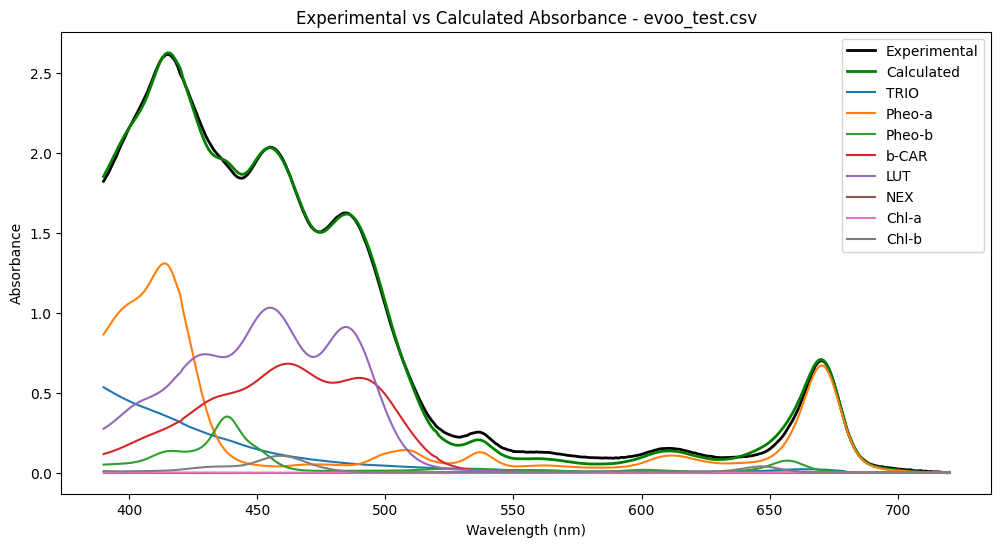

R-square = 0.998976
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =    10.906 mg/kg
Pheo-b       =     1.936 mg/kg
b-CAR        =     3.070 mg/kg
LUT          =     4.922 mg/kg
NEX          =     0.000 mg/kg
Chl-a        =     0.015 mg/kg
Chl-b        =     0.905 mg/kg
-------------------------------
PIGMENT TOTAL =    21.754 mg/kg


In [36]:
analyze_with_regularized_adaptive_model(datasets[0], pigments_data)

## Analysis of Fresh EVOO


Analyzing dataset: fresh_evoo.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/10000], Loss: 0.0177, MSE: 0.0176, L2: 0.0000
Epoch [1000/10000], Loss: 0.0036, MSE: 0.0036, L2: 0.0000
Epoch [1500/10000], Loss: 0.0026, MSE: 0.0026, L2: 0.0000
Epoch [2000/10000], Loss: 0.0019, MSE: 0.0019, L2: 0.0000
Epoch [2500/10000], Loss: 0.0015, MSE: 0.0015, L2: 0.0000
Epoch [3000/10000], Loss: 0.0012, MSE: 0.0012, L2: 0.0000
Epoch [3500/10000], Loss: 0.0011, MSE: 0.0010, L2: 0.0000
Epoch [4000/10000], Loss: 0.0010, MSE: 0.0010, L2: 0.0000
Epoch [4500/10000], Loss: 0.0009, MSE: 0.0009, L2: 0.0000
Epoch [5000/10000], Loss: 0.0008, MSE: 0.0008, L2: 0.0000
Epoch [5500/10000], Loss: 0.0007, MSE: 0.0007, L2: 0.0000
Epoch [6000/10000], Loss: 0.0006, MSE: 0.0006, L2: 0.0000
Epoch [6500/10000], Loss: 0.0006, MSE: 0.0006, L2: 0.0000
Epoch [7000/10000], Loss: 0.0005, MSE: 0.0005, L2: 0.0000
Epoch [7500/10000], Loss: 0.0005, MSE: 0.0005, L2: 0.0000
Epoch [8000/10000], Loss: 0.0005, MSE: 0.0005, L2: 0.0000
Epoch [8500/10000], Loss: 0.0004, MSE: 0.0004, L2: 0.0000
Epoch [9000/100

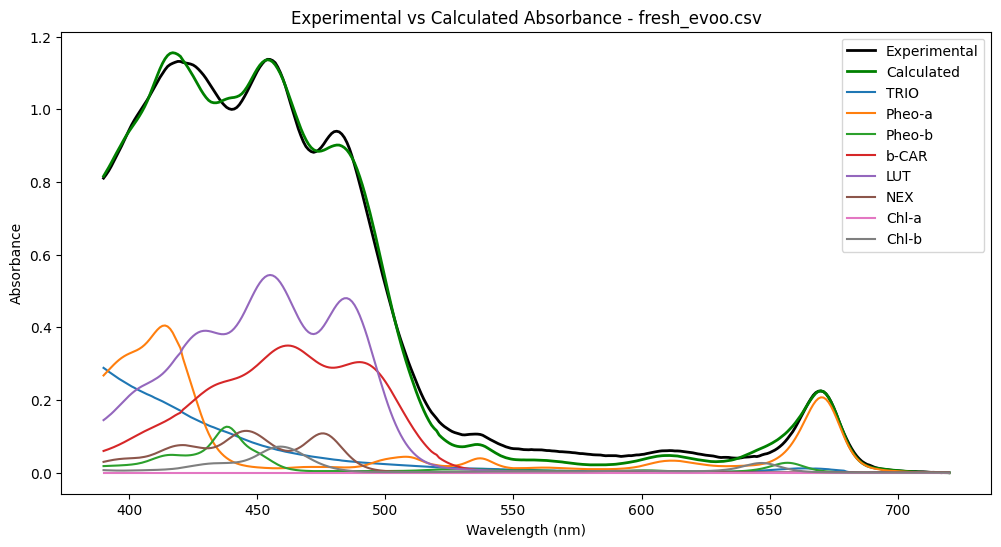

R-square = 0.997664
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     3.375 mg/kg
Pheo-b       =     0.697 mg/kg
b-CAR        =     1.576 mg/kg
LUT          =     2.594 mg/kg
NEX          =     0.610 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     0.615 mg/kg
-------------------------------
PIGMENT TOTAL =     9.467 mg/kg


In [37]:
analyze_with_regularized_adaptive_model(datasets[1], pigments_data)

## Analysis of Maize Seed Oil


Analyzing dataset: mais_seed_oil.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/10000], Loss: 0.0336, MSE: 0.0336, L2: 0.0000
Epoch [1000/10000], Loss: 0.0212, MSE: 0.0212, L2: 0.0000
Epoch [1500/10000], Loss: 0.0145, MSE: 0.0145, L2: 0.0000
Epoch [2000/10000], Loss: 0.0098, MSE: 0.0098, L2: 0.0000
Epoch [2500/10000], Loss: 0.0069, MSE: 0.0069, L2: 0.0000
Epoch [3000/10000], Loss: 0.0054, MSE: 0.0053, L2: 0.0001
Epoch [3500/10000], Loss: 0.0047, MSE: 0.0046, L2: 0.0001
Epoch [4000/10000], Loss: 0.0044, MSE: 0.0044, L2: 0.0001
Epoch [4500/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [5000/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [5500/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [6000/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [6500/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [7000/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [7500/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [8000/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [8500/10000], Loss: 0.0044, MSE: 0.0043, L2: 0.0001
Epoch [9000/100

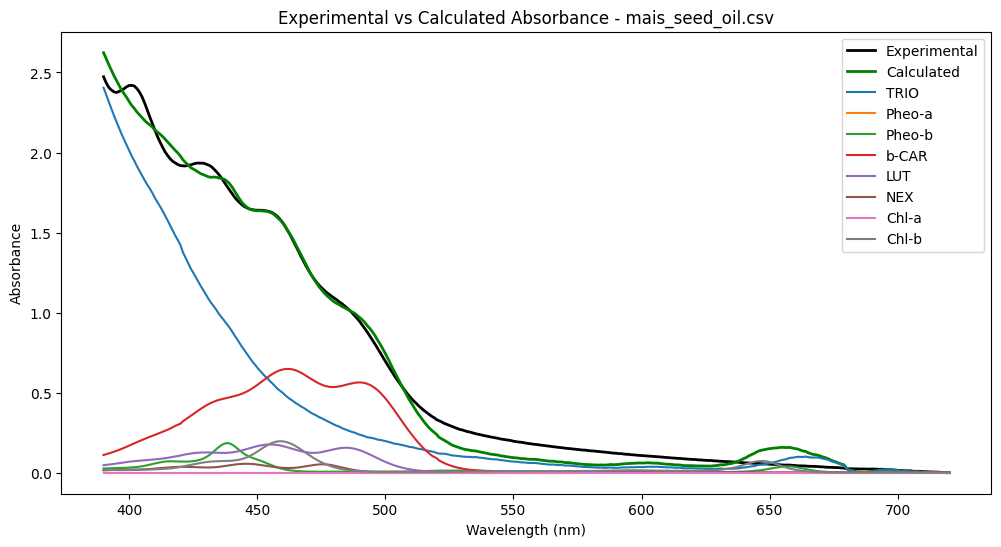

R-square = 0.992894
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     0.000 mg/kg
Pheo-b       =     1.018 mg/kg
b-CAR        =     2.920 mg/kg
LUT          =     0.842 mg/kg
NEX          =     0.297 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     1.683 mg/kg
-------------------------------
PIGMENT TOTAL =     6.761 mg/kg


In [38]:
analyze_with_regularized_adaptive_model(datasets[2], pigments_data)

## Analysis of Monocultivar Frantoio


Analyzing dataset: monocultivar_frantoio.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/10000], Loss: 0.0049, MSE: 0.0048, L2: 0.0000
Epoch [1000/10000], Loss: 0.0022, MSE: 0.0022, L2: 0.0000
Epoch [1500/10000], Loss: 0.0014, MSE: 0.0013, L2: 0.0000
Epoch [2000/10000], Loss: 0.0010, MSE: 0.0010, L2: 0.0000
Epoch [2500/10000], Loss: 0.0009, MSE: 0.0009, L2: 0.0001
Epoch [3000/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [3500/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [4000/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [4500/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [5000/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [5500/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [6000/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Epoch [6500/10000], Loss: 0.0009, MSE: 0.0008, L2: 0.0001
Early stopping at epoch 6570


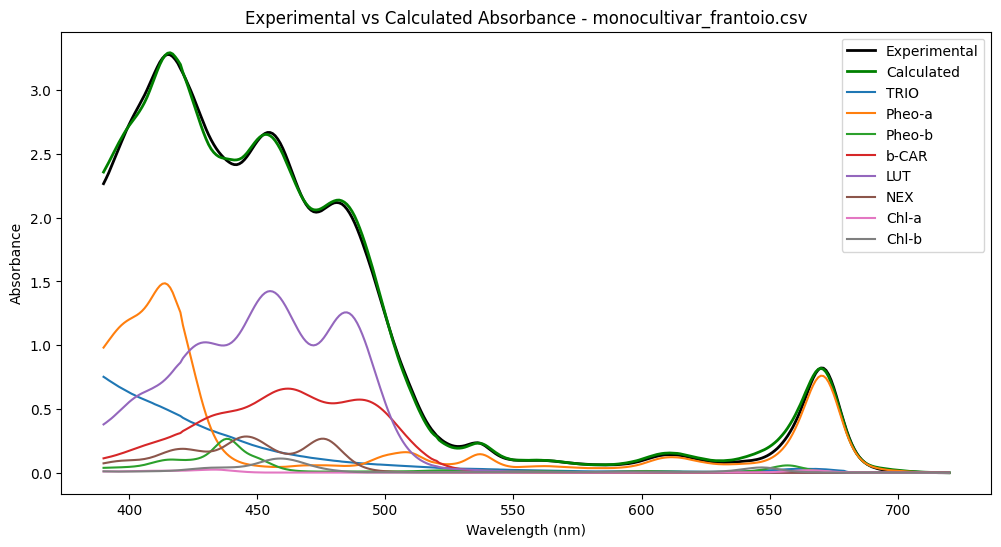

R-square = 0.999351
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =    12.376 mg/kg
Pheo-b       =     1.465 mg/kg
b-CAR        =     2.970 mg/kg
LUT          =     6.793 mg/kg
NEX          =     1.504 mg/kg
Chl-a        =     0.214 mg/kg
Chl-b        =     0.952 mg/kg
-------------------------------
PIGMENT TOTAL =    26.273 mg/kg


In [39]:
analyze_with_regularized_adaptive_model(datasets[3], pigments_data)

## Analysis of Rapeseed Oil


Analyzing dataset: rapeseed_oil.csv


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [500/10000], Loss: 0.0590, MSE: 0.0589, L2: 0.0001
Epoch [1000/10000], Loss: 0.0345, MSE: 0.0344, L2: 0.0001
Epoch [1500/10000], Loss: 0.0239, MSE: 0.0239, L2: 0.0001
Epoch [2000/10000], Loss: 0.0189, MSE: 0.0188, L2: 0.0001
Epoch [2500/10000], Loss: 0.0162, MSE: 0.0162, L2: 0.0001
Epoch [3000/10000], Loss: 0.0144, MSE: 0.0143, L2: 0.0001
Epoch [3500/10000], Loss: 0.0127, MSE: 0.0127, L2: 0.0001
Epoch [4000/10000], Loss: 0.0110, MSE: 0.0110, L2: 0.0001
Epoch [4500/10000], Loss: 0.0093, MSE: 0.0092, L2: 0.0001
Epoch [5000/10000], Loss: 0.0076, MSE: 0.0075, L2: 0.0001
Epoch [5500/10000], Loss: 0.0061, MSE: 0.0060, L2: 0.0001
Epoch [6000/10000], Loss: 0.0047, MSE: 0.0046, L2: 0.0001
Epoch [6500/10000], Loss: 0.0037, MSE: 0.0036, L2: 0.0001
Epoch [7000/10000], Loss: 0.0030, MSE: 0.0029, L2: 0.0001
Epoch [7500/10000], Loss: 0.0025, MSE: 0.0024, L2: 0.0001
Epoch [8000/10000], Loss: 0.0023, MSE: 0.0022, L2: 0.0001
Epoch [8500/10000], Loss: 0.0022, MSE: 0.0021, L2: 0.0001
Epoch [9000/100

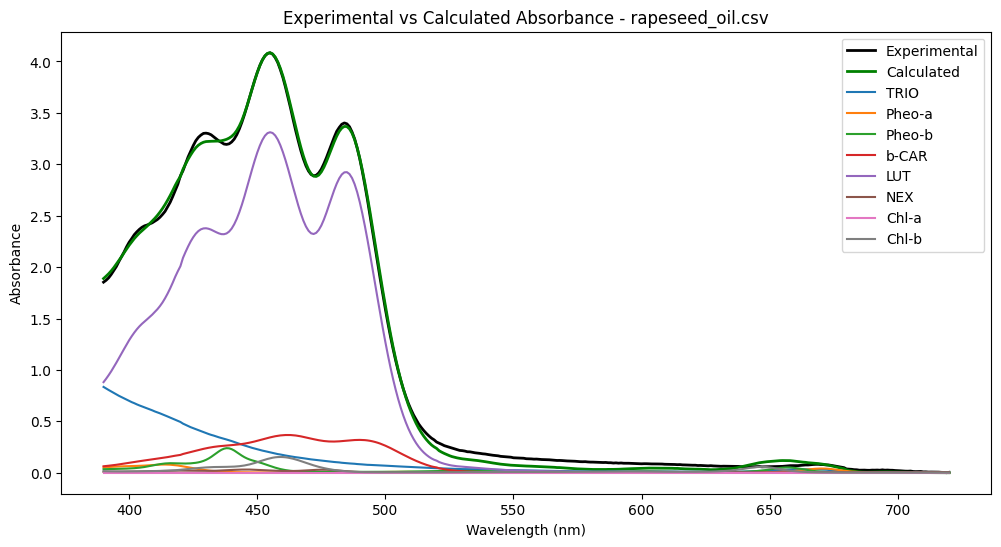

R-square = 0.998951
    PIGMENT CONCENTRATION
-------------------------------
TRIO         = ********* mg/kg
Pheo-a       =     0.665 mg/kg
Pheo-b       =     1.316 mg/kg
b-CAR        =     1.653 mg/kg
LUT          =    15.793 mg/kg
NEX          =     0.165 mg/kg
Chl-a        =     0.000 mg/kg
Chl-b        =     1.310 mg/kg
-------------------------------
PIGMENT TOTAL =    20.902 mg/kg


In [40]:
analyze_with_regularized_adaptive_model(datasets[4], pigments_data)